# Textual Entailments

Textual Entailment is a generalization of many tasks in natural language processing. If you have a system that is good at recognizing textual entailment, it should be easier to build good systems for information retrieval, question answering, paraphrase recognition, information extraction and summarization.


## Task

Given two text fragments, one named text and the other named hypothesis, the task consists in recognizing whether the hypothesis can be inferred from the text.

## Dataset

The Multi-genre NLI Corpus (RepEval 2017) [http://www.nyu.edu/projects/bowman/multinli/] will be used to create the model. The sentence pairs are presented. From source text and promted to...

In [79]:
from __future__ import print_function
%matplotlib inline

from IPython.display import Image, display
from io import BytesIO
import matplotlib.pyplot as plt

import os
from os.path import join, exists
import sys
import numpy as np
import time

import urllib2
import json
from zipfile import ZipFile

import pandas as pd
import pydot_ng as pydot
import graphviz
from ggplot import *


from keras import backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.data_utils import get_file
from keras.utils import to_categorical, plot_model
from keras.models import Sequential, Model, load_model
from keras.layers import Embedding, Dense, Input, Dropout, Reshape, BatchNormalization, TimeDistributed, Lambda, Merge, LSTM, Bidirectional, Convolution1D, GRU, concatenate
from keras.callbacks import Callback, ModelCheckpoint, TensorBoard, BaseLogger, ReduceLROnPlateau
from keras.optimizers import RMSprop, Adam, SGD, Adagrad

In [120]:
dataset_filename = 'multinli_0.9'
training_sample_size = 1000 # Change this to -1 if you want all
max_seq_length = 400

model_name = 'small'

lr = 0.001
lr_decay = 1e-4
epochs = 25
batch_size = 128


# Download Dataset

In [9]:
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
    
def maybe_download(data_root, url, filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = join(data_root, filename)
  if force or not exists(dest_filename):
    print('Attempting to download:', filename) 
    print(url + filename)
    req = urllib2.Request(url + filename)
    req.add_header('Accept', '*/*')
    f = urllib2.urlopen(req)
    total_size = f.info().getheader('Content-Length').strip()
    total_size = int(total_size)
    chunk_size = int(total_size / 100)

    with open(dest_filename, "wb") as local_file:
        bytes_so_far = 0
        count = 0
        while bytes_so_far < total_size:
            chunk = f.read(chunk_size)
            local_file.write(chunk)
            bytes_so_far += len(chunk)
            
            download_progress_hook(count, chunk_size, total_size)
            count += 1

    #filename, _ = urllib2.urlretrieve(url + filename, dest_filename)#, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser? ' + str(statinfo.st_size))
  return dest_filename


In [10]:
multinli_url = 'http://www.nyu.edu/projects/bowman/multinli'
data_folder = './datasets'

if not exists(data_folder):
    os.makedirs(data_folder)

train_filename_zip = maybe_download(data_folder, multinli_url, dataset_filename + '.zip', 227166798)

train_filename = os.path.join(data_folder, dataset_filename, dataset_filename + '_train.jsonl')
if not exists(train_filename):
    zipfile = ZipFile(train_filename_zip, 'r')
    zipfile.extractall(data_folder)
    zipfile.close()

Found and verified ./datasets/multinli_0.9.zip


# Download GloVe

In [11]:
glove_url = 'http://nlp.stanford.edu/data/glove.840B.300d.zip'
embedding_dim = 300
glove_filename = 'glove.840B.' + str(embedding_dim) + 'd.zip'
glove_loc = join(data_folder, glove_filename)

if not exists(glove_loc):
    get_file(glove_filename, glove_url, cache_dir='.', extract=True)

glove_filename = os.path.join(data_folder, 'glove.840B.300d.txt')

embeddings = {}

with open(glove_filename, 'r') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        embeddings[word] = embedding
        
print('Embeddings size: %d' % len(embeddings))

Embeddings size: 2196016


# Data Valuation

## Dataset Corpus

In [114]:
def loadDataset(filename, size=-1):
    label_category = {
        'neutral': 0,
        'entailment': 1,
        'contradiction': 2
    }
    dataset = []
    sentence1 = []
    sentence2 = []
    labels = []
    with open(filename, 'r') as f:
        i = 0
        not_found = 0
        for line in f:
            row = json.loads(unicode(line, 'utf-8'))
            if size == -1 or i < size:
                dataset.append(row)
                label = row['gold_label'].encode('utf-8').strip()
                if label in label_category:
                    sentence1.append( row['sentence1'].encode('utf-8').strip() )
                    sentence2.append( row['sentence2'].encode('utf-8').strip() )

                    labels.append( label_category[label] )
                    i += 1
                else:
                    not_found += 1
            else:
                break;
        if not_found > 0:
            print('Label not recognized %d' % not_found)
                
    return (dataset, sentence1, sentence2, labels)


(train_dataset, train_sentence1, train_sentence2, train_labels) = loadDataset(train_filename, training_sample_size)

train_df = pd.DataFrame(train_dataset)

train_df.head()

,annotator_labels,genre,gold_label,pairID,promptID,sentence1,sentence1_binary_parse,sentence1_parse,sentence2,sentence2_binary_parse,sentence2_parse
0,[neutral],government,neutral,335730n,335730n,Conceptually cream skimming has two basic dime...,( ( Conceptually ( cream skimming ) ) ( ( has ...,(ROOT (S (NP (JJ Conceptually) (NN cream) (NN ...,Product and geography are what make cream skim...,( ( ( Product and ) geography ) ( ( are ( what...,(ROOT (S (NP (NN Product) (CC and) (NN geograp...
1,[entailment],telephone,entailment,249628e,249628e,you know during the season and i guess at at y...,( you ( ( know ( during ( ( ( the season ) and...,(ROOT (S (NP (PRP you)) (VP (VBP know) (PP (IN...,You lose the things to the following level if ...,( You ( ( ( ( lose ( the things ) ) ( to ( the...,(ROOT (S (NP (PRP You)) (VP (VBP lose) (NP (DT...
2,[entailment],fiction,entailment,169837e,169837e,One of our number will carry out your instruct...,( ( One ( of ( our number ) ) ) ( ( will ( ( (...,(ROOT (S (NP (NP (CD One)) (PP (IN of) (NP (PR...,A member of my team will execute your orders w...,( ( ( A member ) ( of ( my team ) ) ) ( ( will...,(ROOT (S (NP (NP (DT A) (NN member)) (PP (IN o...
3,[entailment],fiction,entailment,155402e,155402e,How do you know? All this is their information...,( ( How ( ( ( do you ) know ) ? ) ) ( ( All th...,(ROOT (S (SBARQ (WHADVP (WRB How)) (SQ (VBP do...,This information belongs to them.,( ( This information ) ( ( belongs ( to them )...,(ROOT (S (NP (DT This) (NN information)) (VP (...
4,[neutral],telephone,neutral,416658n,416658n,yeah i tell you what though if you go price so...,( yeah ( i ( ( tell you ) ( what ( ( though ( ...,(ROOT (S (VP (VB yeah) (S (NP (FW i)) (VP (VB ...,The tennis shoes have a range of prices.,( ( The ( tennis shoes ) ) ( ( have ( ( a rang...,(ROOT (S (NP (DT The) (NN tennis) (NNS shoes))...


In [13]:
train_df.genre.unique()

array([u'government', u'telephone', u'fiction', u'travel', u'slate'], dtype=object)

In [14]:
train_df.gold_label.unique()

array([u'neutral', u'entailment', u'contradiction'], dtype=object)

In [15]:
gold_label = train_df['gold_label']
print('neutral: %d' % gold_label[gold_label == 'neutral'].count())
print('entailment: %d' % gold_label[gold_label == 'entailment'].count())
print('contradiction: %d' % gold_label[gold_label == 'contradiction'].count())


neutral: 282
entailment: 343
contradiction: 375


In [16]:
train_df.iloc[0]

annotator_labels                                                  [neutral]
genre                                                            government
gold_label                                                          neutral
pairID                                                              335730n
promptID                                                            335730n
sentence1                 Conceptually cream skimming has two basic dime...
sentence1_binary_parse    ( ( Conceptually ( cream skimming ) ) ( ( has ...
sentence1_parse           (ROOT (S (NP (JJ Conceptually) (NN cream) (NN ...
sentence2                 Product and geography are what make cream skim...
sentence2_binary_parse    ( ( ( Product and ) geography ) ( ( are ( what...
sentence2_parse           (ROOT (S (NP (NN Product) (CC and) (NN geograp...
Name: 0, dtype: object

## Prepare Word Embeddings

In [117]:
NUM_WORDS = len(embeddings) #200000

print('Found %s samples.' % len(train_sentence1))

train_sentences = train_sentence1 + train_sentence2

tokenizer = Tokenizer(num_words = NUM_WORDS)
tokenizer.fit_on_texts(train_sentences)
sentence1_word_sequences = tokenizer.texts_to_sequences(train_sentence1)
sentence2_word_sequences = tokenizer.texts_to_sequences(train_sentence2)
word_index = tokenizer.word_index

print('Found %s unique tokens.' % len(word_index))

Found 392702 samples.
Found 77556 unique tokens.


In [118]:
from collections import defaultdict

words_len = min(NUM_WORDS, len(word_index))
# word_embedding_matrix = np.zeros((words_len + 1, embedding_dim))
word_embedding_matrix = np.random.random((words_len + 1, embedding_dim))
k = 0
for word, i in word_index.items():
    if i >= NUM_WORDS:
        continue
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        word_embedding_matrix[i] = embedding_vector
        k += 1
        
max_word_count_text = 0
text_count = defaultdict(int)
for sentence in sentence1_word_sequences:
    max_word_count_text = max(max_word_count_text, len(sentence))
    text_count[len(sentence)] += 1

max_word_count_hypo = 0
hypo_count = defaultdict(int)
for sentence in sentence2_word_sequences:
    max_word_count_hypo = max(max_word_count_hypo, len(sentence))
    hypo_count[len(sentence)] += 1
        

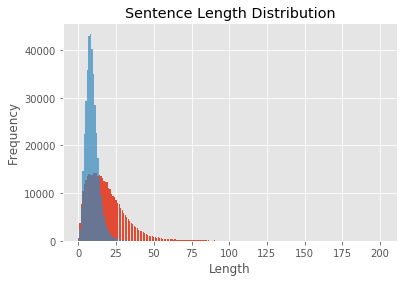

In [119]:

mpl_fig = plt.figure()
ax = mpl_fig.add_subplot(111)

ax.bar(range(len(text_count)), text_count.values())
ax.bar(range(len(hypo_count)), hypo_count.values(), alpha=0.7)

plt.title("Sentence Length Distribution")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()

In [19]:
print('Null word embeddings: %d' % (np.sum(np.sum(word_embedding_matrix, axis=1) == 0) - 1))
print('Found %d' % k)
print('Total: %d' % len(word_embedding_matrix))
print('Max word text: %d' % max_word_count_text)
print('Max word hypothesis: %d' % max_word_count_hypo)

Null word embeddings: -1
Found 5524
Total: 5837
Max word text: 171
Max word hypothesis: 46


In [20]:
s1_data = pad_sequences(sentence1_word_sequences, maxlen = max_seq_length)
s2_data = pad_sequences(sentence2_word_sequences, maxlen = max_seq_length)

labels = to_categorical(np.asarray(train_labels))

print('Shape of sentence1 tensor:', s1_data.shape)
print('Shape of sentence2 tensor:', s2_data.shape)
print('Shape of label tensor:', labels.shape)

Shape of sentence1 tensor: (1000, 400)
Shape of sentence2 tensor: (1000, 400)
Shape of label tensor: (1000, 3)


In [21]:
print('One sample')

print('Text: ')
print( train_sentence1[0] )

print('Word sequence: ')
print( sentence1_word_sequences[0] )

print('Pad: ')
print( s1_data[0] )

One sample
Text: 
Conceptually cream skimming has two basic dimensions - product and geography.
Word sequence: 
[3369, 1852, 2341, 31, 81, 1058, 3356, 767, 3, 2143]
Pad: 
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    

# Tensor Model

I have 77556 words which will be encoded to 300 embedings.
input_length=25 ? should I increase it.

In [89]:
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def fbeta_score(y_true, y_pred, beta=1):
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score

models = {};

def create_model(name, add_lsmt):
    seq_sentence1 = Sequential()
    seq_sentence1.add(Embedding(words_len + 1,
                     embedding_dim,
                     weights = [word_embedding_matrix],
                     input_length = max_seq_length,
                     trainable = False
                               ))
    #if add_lsmt:
    #    seq_sentence1.add(Convolution1D(128, 5, border_mode='same', activation='relu'))
    #    seq_sentence1.add(Dropout(0.25))
    #    seq_sentence1.add(GRU(embedding_dim, return_sequences=True))
    #    # seq_sentence1.add(LSTM(embedding_dim, return_sequences=True))
    seq_sentence1.add(TimeDistributed(Dense(embedding_dim, activation='relu')))
    seq_sentence1.add(Lambda(lambda x: K.max(x, axis=1), output_shape=(embedding_dim, )))

    seq_sentence2 = Sequential()
    seq_sentence2.add(Embedding(words_len + 1,
                     embedding_dim,
                     weights = [word_embedding_matrix],
                     input_length = max_seq_length,
                     trainable = False
                               ))
    #if add_lsmt:
    #    seq_sentence2.add(Convolution1D(128, 5, border_mode='same', activation='relu'))
    #    seq_sentence2.add(Dropout(0.25))
    #    seq_sentence2.add(GRU(embedding_dim, return_sequences=True))
    #    #seq_sentence2.add(LSTM(embedding_dim, return_sequences=True))
    seq_sentence2.add(TimeDistributed(Dense(embedding_dim, activation='relu')))
    seq_sentence2.add(Lambda(lambda x: K.max(x, axis=1), output_shape=(embedding_dim, )))
    
    model = Sequential()
    model.add(Merge([seq_sentence1, seq_sentence2], mode='concat'))
    
    #if add_lsmt:
    #    model.add(LSTM(embedding_dim, return_sequences=True))
    
    model.add(BatchNormalization())
    model.add(Dense(200, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(200, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(200, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(200, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(3, activation='sigmoid'))
    
    if name == 'adam':
        optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    elif name == 'rmsprop':
        optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
    elif name == 'sgd-momentum':
        optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    elif name == 'adagrad':
        optimizer = Adagrad(lr=0.01, epsilon=1e-08, decay=0.0)
        
    #optimizer = Adam(lr=lr, decay=lr_decay)

    model.compile(loss = 'categorical_crossentropy', 
              optimizer = optimizer, 
              #loss_weights = [1., 0.2],
              metrics = ['accuracy']) #, precision, recall, fbeta_score])
    return model

#    models[name]  = model

    
models['adam_simple'] = create_model('adam', False)
models['adam_lstm'] = create_model('adam', True)

models['rmsprop_simple'] = create_model('rmsprop', False)
models['rmsprop_lstm'] = create_model('rmsprop', True)

#create_model('adam')
#create_model('rmsprop')
#create_model('sgd-momentum')
#create_model('adagrad')

'''
    #seq_sentence2.add(Bidirectional(LSTM(embedding_dim / 2)))
    #seq_sentence2.add(TimeDistributed(Dense(embedding_dim, activation='relu')))
    #seq_sentence2.add(Lambda(lambda x: K.max(x, axis=1), output_shape=(embedding_dim, )))

    text_input = Input(shape=(words_len + 1, max_seq_length))
    hypothesis_input = Input(shape=(words_len + 1, max_seq_length))

    merged_vector = concatenate([text_input, hypothesis_input])

    act = Dense(200, activation='relu')(merged_vector)
    batch = BatchNormalization()(act)

    act = Dense(200, activation='relu')(batch)
    batch = BatchNormalization()(act)

    act = Dense(200, activation='relu')(batch)
    batch = BatchNormalization()(act)

    act = Dense(200, activation='relu')(batch)
    batch = BatchNormalization()(act)

    output = Dense(3, activation='sigmoid')(batch)

    model = Model(inputs=[text_input, hypothesis_input], outputs=output)

optimizer = Adam(lr=lr, decay=lr_decay)

model.compile(loss = 'categorical_crossentropy', 
              optimizer = optimizer, 
              #loss_weights = [1., 0.2],
              metrics = ['accuracy', precision, recall, fbeta_score])

models['categorical']  = model
'''

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:56: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


"\n    #seq_sentence2.add(Bidirectional(LSTM(embedding_dim / 2)))\n    #seq_sentence2.add(TimeDistributed(Dense(embedding_dim, activation='relu')))\n    #seq_sentence2.add(Lambda(lambda x: K.max(x, axis=1), output_shape=(embedding_dim, )))\n\n    text_input = Input(shape=(words_len + 1, max_seq_length))\n    hypothesis_input = Input(shape=(words_len + 1, max_seq_length))\n\n    merged_vector = concatenate([text_input, hypothesis_input])\n\n    act = Dense(200, activation='relu')(merged_vector)\n    batch = BatchNormalization()(act)\n\n    act = Dense(200, activation='relu')(batch)\n    batch = BatchNormalization()(act)\n\n    act = Dense(200, activation='relu')(batch)\n    batch = BatchNormalization()(act)\n\n    act = Dense(200, activation='relu')(batch)\n    batch = BatchNormalization()(act)\n\n    output = Dense(3, activation='sigmoid')(batch)\n\n    model = Model(inputs=[text_input, hypothesis_input], outputs=output)\n\noptimizer = Adam(lr=lr, decay=lr_decay)\n\nmodel.compile(loss 

In [ ]:
'''
model = Sequential()
model.add(Merge([seq_sentence1, seq_sentence2], mode='concat'))
model.add(BatchNormalization())
model.add(Dense(200, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(200, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(200, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(200, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(200, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(3, activation='sigmoid'))

# loss -> categorical_crossentropy
# binary_crossentropy

optimizer = Adam(lr = lr, decay = lr_decay)

model.compile(loss = 'binary_crossentropy', 
              optimizer = optimizer, 
              #loss_weights = [1., 0.2],
              metrics = ['accuracy']) #'precision', 'recall', 'fbeta_score'
# models['binary']  = model

'''

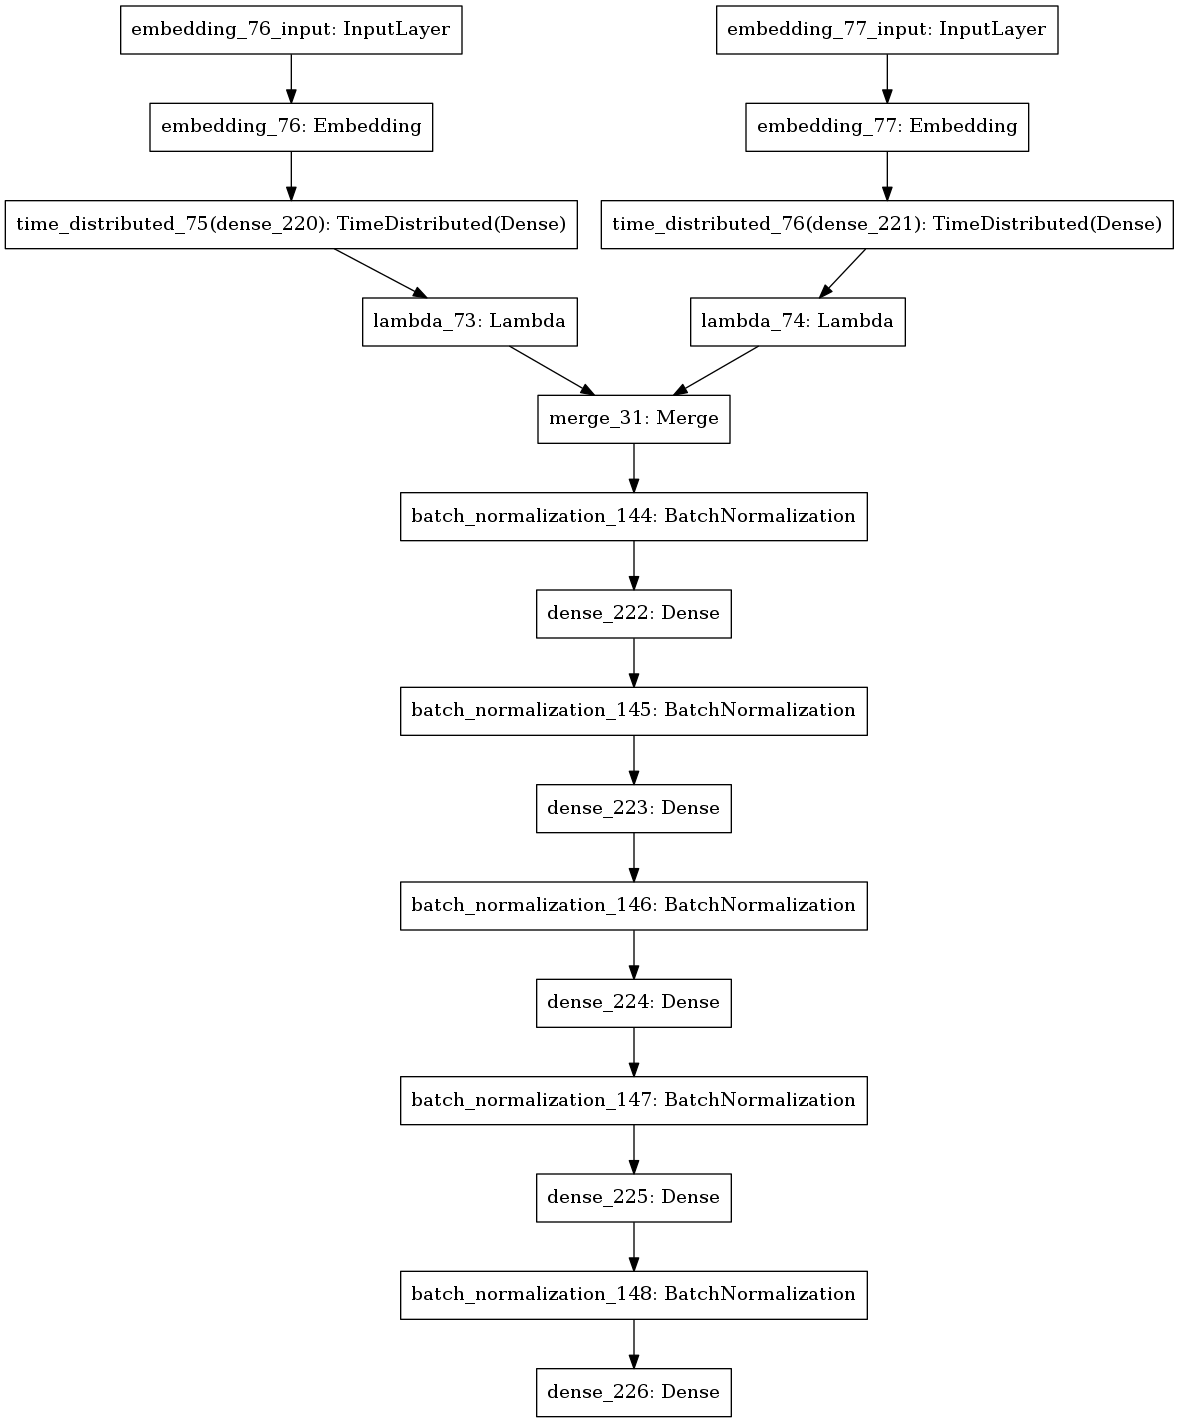

In [91]:
plot_model(models['rmsprop_simple'], to_file = model_name + '-model.png', show_shapes=False)
Image(filename = model_name + '-model.png') 

## Train Model

In [81]:
results = []
for name, model in models.items():
    callbacks = [
        BaseLogger(),
        ReduceLROnPlateau(monitor = 'val_loss', factor=0.2, patience=5, min_lr=0.001),
        TensorBoard(log_dir='./' + model_name + '-' + name + '-logs', histogram_freq=0, write_graph=True, write_images=True),
        ModelCheckpoint(model_name + '-' + name + '-checkpoint-weights.{epoch:02d}-{val_acc:.2f}.hdf5', monitor='val_acc', save_best_only=True)
    ]
    
    start_time = time.time()
    print('')
    print('Start learning %s at %d' % (name, start_time))
    print('Epochs: %d' % epochs)
    print('Batch size: %d' % batch_size)

    history = model.fit([s1_data, s2_data],
                        labels,
                        epochs = epochs,
                        batch_size = batch_size,
                        validation_split = 0.1,
                        shuffle = False, #True,
                        verbose = 2,
                        callbacks = callbacks)

    model.save(model_name + '-' + name + '-model.h5')
    model.save_weights(model_name + '-' + name + '-weights.h5')

    end_time = time.time()
    average_time_per_epoch = (end_time - start_time) / epochs
    results.append((history, average_time_per_epoch))
    
    #print('End learning: %d' % end_time)
    print('Time: %d' % (end_time - start_time))
    


Start learning rmsprop_simple at 1494231977
Epochs: 2
Batch size: 128
Train on 900 samples, validate on 100 samples
Epoch 1/2
13s - loss: 1.1957 - acc: 0.3567 - val_loss: 1.1030 - val_acc: 0.2700
Epoch 2/2
10s - loss: 0.6616 - acc: 0.8089 - val_loss: 1.1116 - val_acc: 0.3100
Time: 32

Start learning adam_simple at 1494232010
Epochs: 2
Batch size: 128
Train on 900 samples, validate on 100 samples
Epoch 1/2
13s - loss: 1.2188 - acc: 0.3356 - val_loss: 1.1083 - val_acc: 0.2600
Epoch 2/2
10s - loss: 0.6987 - acc: 0.7967 - val_loss: 1.1078 - val_acc: 0.3300
Time: 33

Start learning rmsprop_lstm at 1494232043
Epochs: 2
Batch size: 128
Train on 900 samples, validate on 100 samples
Epoch 1/2
64s - loss: 1.2365 - acc: 0.3322 - val_loss: 1.0961 - val_acc: 0.3100
Epoch 2/2
60s - loss: 1.2120 - acc: 0.3578 - val_loss: 1.1017 - val_acc: 0.3100
Time: 135

Start learning adam_lstm at 1494232179
Epochs: 2
Batch size: 128
Train on 900 samples, validate on 100 samples
Epoch 1/2
107s - loss: 1.2201 - ac

In [ ]:
#model = load_model('model6-text-entailment-2017-04-24.h5')
#model.load_weights('weights6-text-entailment-2017-04-24.h5')


In [27]:
max_val_acc, idx = max((val, idx) for (idx, val) in enumerate(history.history['val_acc']))
print('Max acc at epoch ', (idx + 1), ' = ', max_val_acc)

Max acc at epoch  1  =  0.381999999046


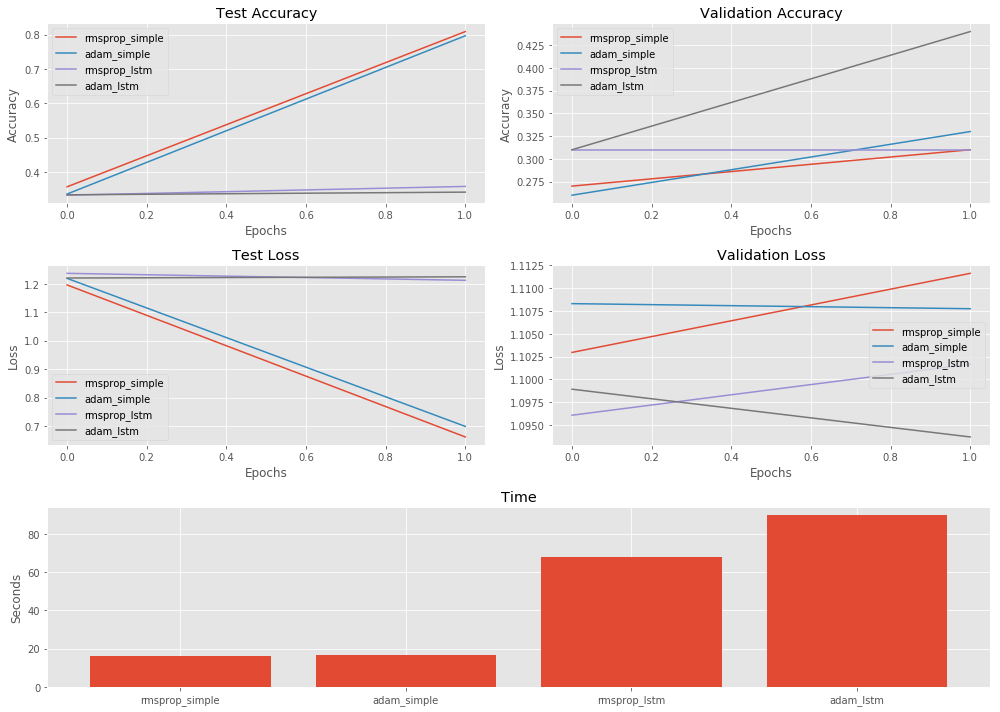

In [82]:
#acc = pd.DataFrame({
#    'epoch': [ i + 1 for i in history.epoch ],
#    'training': history.history['acc'],
#    'validation': history.history['val_acc']
#})
#
#ax = acc.ix[:,:].plot(x='epoch', figsize={5,8}, grid = True)
#ax.set_ylabel('accuracy')
#ax.set_ylim([0.0, 1.0])

plt.style.use('ggplot')
plt.figure(figsize=(14, 10))#, dpi=100)

ax1 = plt.subplot2grid((3, 2), (0, 0))
ax1.set_title('Test Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epochs')

ax2 = plt.subplot2grid((3, 2), (1, 0))
ax2.set_title('Test Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epochs')

ax3 = plt.subplot2grid((3, 2), (0, 1))
ax3.set_title('Validation Accuracy')
ax3.set_ylabel('Accuracy')
ax3.set_xlabel('Epochs')

ax4 = plt.subplot2grid((3, 2), (1, 1))
ax4.set_title('Validation Loss')
ax4.set_ylabel('Loss')
ax4.set_xlabel('Epochs')

ax5 = plt.subplot2grid((3, 2), (2, 0), rowspan=1, colspan=2)
ax5.set_title('Time')
ax5.set_ylabel('Seconds')

for mode, result in zip(models, results):
    ax1.plot(result[0].epoch, result[0].history['acc'], label=mode)
    ax2.plot(result[0].epoch, result[0].history['loss'], label=mode)
    ax3.plot(result[0].epoch, result[0].history['val_acc'], label=mode)
    ax4.plot(result[0].epoch, result[0].history['val_loss'], label=mode)
    
ax1.legend()
ax2.legend()

ax3.legend()
ax4.legend()

ax5.bar(np.arange(len(results)), [x[1] for x in results],
        tick_label=models, align='center')

plt.tight_layout()
plt.savefig(model_name + '-acc-loss.png', dpi = 300)
#plt.show()

# Test Matched

In [55]:
matched_filename = os.path.join(data_folder, dataset_filename, dataset_filename + '_dev_matched.jsonl')

(_, matched_sentence1, matched_sentence2, matched_labels_text) = loadDataset(matched_filename)

matched_s1_word_sequences = tokenizer.texts_to_sequences(matched_sentence1)
matched_s2_word_sequences = tokenizer.texts_to_sequences(matched_sentence2)

matched_s1_data = pad_sequences(matched_s1_word_sequences, maxlen = max_seq_length)
matched_s2_data = pad_sequences(matched_s2_word_sequences, maxlen = max_seq_length)
matched_labels = to_categorical(np.asarray(matched_labels_text))

print('Shape of test sentence1 tensor:', matched_s1_data.shape)
print('Shape of test sentence2 tensor:', matched_s2_data.shape)
print('Shape of test label tensor:', matched_labels.shape)

Label not recognized 185
Shape of test sentence1 tensor: (9815, 400)
Shape of test sentence2 tensor: (9815, 400)
Shape of test label tensor: (9815, 3)


In [83]:
for name, model in models.items():
    print('')
    print('Model %s' % name)
    
    loss, accuracy = model.evaluate([matched_s1_data, matched_s2_data], matched_labels)
    
    print('loss     = ', loss)
    print('accuracy = ', accuracy)


Model rmsprop_simple
9815/9815 [==============================] - 22s    
loss     =  1.09817682891
accuracy =  0.355578196653

Model adam_simple
9815/9815 [==============================] - 22s    
loss     =  1.09689898142
accuracy =  0.350280183359

Model rmsprop_lstm
9815/9815 [==============================] - 217s   
loss     =  1.09715584795
accuracy =  0.354457463082

Model adam_lstm
9815/9815 [==============================] - 217s   
loss     =  1.09939196202
accuracy =  0.327356087636


# Test Mismatched

In [58]:
mismatched_filename = os.path.join(data_folder, dataset_filename, dataset_filename + '_dev_mismatched.jsonl')
(_, mismatched_sentence1, mismatched_sentence2, mismatched_labels_text) = loadDataset(matched_filename)

mismatched_s1_word_sequences = tokenizer.texts_to_sequences(mismatched_sentence1)
mismatched_s2_word_sequences = tokenizer.texts_to_sequences(mismatched_sentence2)

mismatched_s1_data = pad_sequences(mismatched_s1_word_sequences, maxlen = max_seq_length)
mismatched_s2_data = pad_sequences(mismatched_s2_word_sequences, maxlen = max_seq_length)
mismatched_labels = to_categorical(np.asarray(mismatched_labels_text))

print('Shape of test sentence1 tensor:', mismatched_s1_data.shape)
print('Shape of test sentence2 tensor:', mismatched_s2_data.shape)
print('Shape of test label tensor:', mismatched_labels.shape)

Label not recognized 185
Shape of test sentence1 tensor: (9815, 400)
Shape of test sentence2 tensor: (9815, 400)
Shape of test label tensor: (9815, 3)


In [84]:
for name, model in models.items():
    loss, accuracy = model.evaluate([mismatched_s1_data, mismatched_s2_data], mismatched_labels)
    print('')
    print('Model %s' % name)
    print('loss     = ', loss)
    print('accuracy = ', accuracy)

9815/9815 [==============================] - 22s    

Model rmsprop_simple
loss     =  1.09817682891
accuracy =  0.355578196653
9815/9815 [==============================] - 21s    

Model adam_simple
loss     =  1.09689898142
accuracy =  0.350280183359
9815/9815 [==============================] - 217s   

Model rmsprop_lstm
loss     =  1.09715584795
accuracy =  0.354457463082
9815/9815 [==============================] - 217s   

Model adam_lstm
loss     =  1.09939196202
accuracy =  0.327356087636
